# Lab Exercises

## Jack's Rental Car

*Example from the book Reinforcement Learning: An Introduction*

Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he rents it out and is credited $10 by the national company. If he is out of cars at that location, then the business is lost. Cars become available for renting the day after they are returned. To help ensure that cars are available where they are needed, Jack can move them between two locations overnight, at a cost of $2 per car moved. We assume that the number of cars requested and returned at each location are Poisson random variables. Suppose lambda is 3 and 4 for rental requests at the first ans second locations and 3 and 2 for returns. A maximum of five cars can be moved from one location to the other in one night.

One of Jack's employees at the first location rides a bus home each night and lives near the second location. She is happy to shuttle one car to the second location for free. Each additional car still costs 2$, as do all cars moved in the other direction. In addition, Jack has limited parking space at each location. If more than 10 cars are kept overnight at a location (after any moving of cars), then an additional cost of $4 must be incurred to use a second parking lot (independent of how many cars kept there). These sorts of nonlinearities and arbitrary dynamics often occur in real problems and cannot easily be handled by optimization methods other than dynamic programming.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import poisson
from policy_iteration import policy_iteration

Definiciones del problema:

In [3]:
max_cars = 20
max_mov = 5
rental_reward = 10
move_cost = 2
parking_limit = 10
extra_parking_cost = 4

lambda_rent_1 = 3
lambda_return_1 = 3
lambda_rent_2 = 4
lambda_return_2 = 2

states = [(i, j) for i in range(max_cars + 1) for j in range(max_cars + 1)]
actions = {s: [a for a in range(-max_mov, max_mov + 1)
               if 0 <= s[0] - a <= max_cars and 0 <= s[1] + a <= max_cars]
            for s in states}

In [9]:
states[:10], actions

([(0, 0),
  (0, 1),
  (0, 2),
  (0, 3),
  (0, 4),
  (0, 5),
  (0, 6),
  (0, 7),
  (0, 8),
  (0, 9)],
 {(0, 0): [0],
  (0, 1): [-1, 0],
  (0, 2): [-2, -1, 0],
  (0, 3): [-3, -2, -1, 0],
  (0, 4): [-4, -3, -2, -1, 0],
  (0, 5): [-5, -4, -3, -2, -1, 0],
  (0, 6): [-5, -4, -3, -2, -1, 0],
  (0, 7): [-5, -4, -3, -2, -1, 0],
  (0, 8): [-5, -4, -3, -2, -1, 0],
  (0, 9): [-5, -4, -3, -2, -1, 0],
  (0, 10): [-5, -4, -3, -2, -1, 0],
  (0, 11): [-5, -4, -3, -2, -1, 0],
  (0, 12): [-5, -4, -3, -2, -1, 0],
  (0, 13): [-5, -4, -3, -2, -1, 0],
  (0, 14): [-5, -4, -3, -2, -1, 0],
  (0, 15): [-5, -4, -3, -2, -1, 0],
  (0, 16): [-5, -4, -3, -2, -1, 0],
  (0, 17): [-5, -4, -3, -2, -1, 0],
  (0, 18): [-5, -4, -3, -2, -1, 0],
  (0, 19): [-5, -4, -3, -2, -1, 0],
  (0, 20): [-5, -4, -3, -2, -1, 0],
  (1, 0): [0, 1],
  (1, 1): [-1, 0, 1],
  (1, 2): [-2, -1, 0, 1],
  (1, 3): [-3, -2, -1, 0, 1],
  (1, 4): [-4, -3, -2, -1, 0, 1],
  (1, 5): [-5, -4, -3, -2, -1, 0, 1],
  (1, 6): [-5, -4, -3, -2, -1, 0, 1],
  (1, 7

Poisson Cache:

In [18]:
from functools import lru_cache
import math

@lru_cache(maxsize=None)
def poisson_prob(n, lam):
    return (lam**n) * np.exp(-lam) / math.factorial(n)

Función de transición:

In [16]:
global call_counter
call_counter = 0
def transition_function(state, action):
    global call_counter
    call_counter += 1
    if call_counter % 1000 == 0:
        print(f"transition_function has been called {call_counter} times.")
    s1, s2 = state
    # Movimiento de coches (ajustando por transporte gratis de 1 coche de loc 1 a loc 2)
    real_action = np.clip(action, -max_mov, max_mov)
    moved_cars = real_action
    s1_ = min(s1 - moved_cars, max_cars)
    s2_ = min(s2+ moved_cars, max_cars)

    results = []

    for req1 in range(0, 6):
        for ret1 in range(0, 6):
            prob_r1 = poisson_prob(req1, lambda_rent_1) * poisson_prob(ret1, lambda_return_1)
            num_rent1 = min(s1_, req1)
            cars1 = min(s1_ - num_rent1 + ret1, max_cars)

            for req2 in range(0, 11):
                for ret2 in range(0, 11):
                    prob_r2 = poisson_prob(req2, lambda_rent_2) * poisson_prob(ret2, lambda_return_2)
                    num_rent2 = min(s2_, req2)
                    cars2 = min(s2_ - num_rent2 + ret2, max_cars)

                    reward = (num_rent1 + num_rent2) * rental_reward
                    cost = 0

                    if action > 0:
                        cost += (action - 1) * move_cost
                    elif action < 0:
                        cost += abs(action) * move_cost

                    if cars1 > parking_limit:
                        cost += extra_parking_cost
                    if cars2 > parking_limit:
                        cost += extra_parking_cost
                    
                    total_prob = prob_r1 * prob_r2
                    next_state = (cars1, cars2)
                    results.append((next_state, reward - cost, total_prob))

    return results

Ejecutar `policy_iteration()`

In [19]:
policy, V = policy_iteration(states, actions, transition_function, gamma=0.99)

transition_function has been called 1000 times.
transition_function has been called 2000 times.
transition_function has been called 3000 times.
transition_function has been called 4000 times.
transition_function has been called 5000 times.
transition_function has been called 6000 times.
transition_function has been called 7000 times.
transition_function has been called 8000 times.
transition_function has been called 9000 times.
transition_function has been called 10000 times.
transition_function has been called 11000 times.
transition_function has been called 12000 times.
transition_function has been called 13000 times.
transition_function has been called 14000 times.
transition_function has been called 15000 times.
transition_function has been called 16000 times.
transition_function has been called 17000 times.
transition_function has been called 18000 times.
transition_function has been called 19000 times.
transition_function has been called 20000 times.
transition_function has been 

Visualización:

In [20]:
def plot_policy(policy):
    grid = np.zeros((max_cars + 1, max_cars + 1))
    for (i, j), a in policy.items():
        grid[i, j] = a
    plt.figure(figsize=(6, 5))
    plt.title('Policy')
    plt.imshow(grid, origin='lower', cmap='viridis', vmin=-5, vmax=5)
    plt.colorbar()
    plt.xlabel('Cars at Location 2')
    plt.ylabel('Cars at Location 1')
    plt.show()

def plot_value_function(V):
    grid = np.zeros((max_cars + 1, max_cars + 1))
    for (i, j), a in policy.items():
        grid[i, j] = a
    plt.figure(figsize=(6, 5))
    plt.title('Policy')
    plt.imshow(grid, origin='lower', cmap='viridis', vmin=-5, vmax=5)
    plt.colorbar()
    plt.xlabel('Cars at Location 2')
    plt.ylabel('Cars at Location 1')
    plt.show()

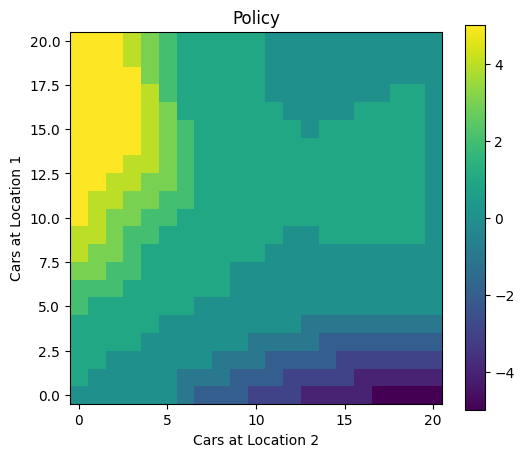

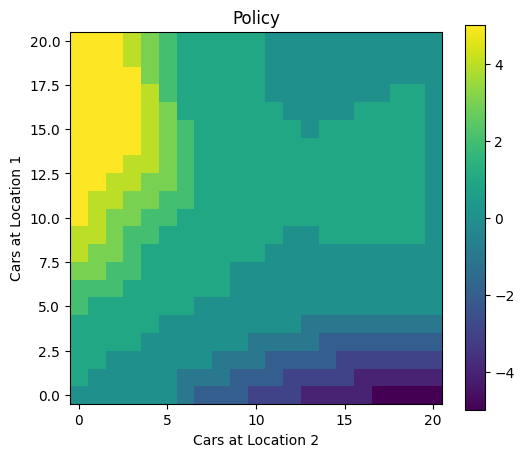

In [21]:
plot_policy(policy)
plot_value_function(V)

## Gambler's Problem

A gambler has the opportunity to make bets on the outcomes of a sequence of coin flips. If the coin comes up heads, he wins as many dollars as he has staked on that flip; if it is tails, he loses his stake. The game ends when the gambler wins by reaching his goal of $100, or loses by running out of money. On each flip, the gambkler must decide what portion of his capital to stake, in integer numbers of dollars.

This problem can be formulated as an undiscounted, episodic, finite MDP. The state is the gambler's capital, and the actions are stakes. The reward is zero on all transitions except those which the gambler reaches his goal, when it is +1. 

Let $p_h$ denote the probability of the coin coming up heads. If $p_h$ is known, then the entire problem is known and it can be solved, for instance, by value iteration.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from value_iteration import value_iteration

In [25]:
# Configuración del juego:
# STATES
states = [i for i in range(101)]
terminal_states = [0, 100]
# ACTIONS
actions = {}
for s in states:
    if s in terminal_states:
        actions[s] = []
    else:
        actions[s] = range(1, min(s, 100 - s))
# REWARD
reward = {s: 1 if s == 100 else 0 for s in states}
# Probability of heads
p_h = 0.55